In [429]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import log_loss
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
pal = sns.color_palette()
%matplotlib inline
from statistics import mean, stdev
from wordcloud import WordCloud
import pickle
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from collections import Counter

## Data Summary

In [405]:
qs_train = pd.read_csv('./Data/train.csv').fillna("")
qs_train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


In [326]:
qs_test = pd.read_csv('./Data/test.csv').fillna("")
qs_test.head(10)

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?
5,5,How are the two wheeler insurance from Bharti ...,I admire I am considering of buying insurance ...
6,6,How can I reduce my belly fat through a diet?,How can I reduce my lower belly fat in one month?
7,7,"By scrapping the 500 and 1000 rupee notes, how...",How will the recent move to declare 500 and 10...
8,8,What are the how best books of all time?,What are some of the military history books of...
9,9,After 12th years old boy and I had sex with a ...,Can a 14 old guy date a 12 year old girl?


`id`: Row ID

`qid{1, 2}`: Unique question ID for the 2 questions in the pair

`question{1, 2}`: The text contents of the 2 questions

`is_duplicate`: The **label** of whether the questions in the pair are duplicates (with same meaning) of each other, 1: duplicated, 2: not duplicated

In [59]:
print('\n', '-'*15+'Training Data Summary'+'-'*15, '\n')
print('Number of question pairs: {}'.format(len(qs_train)))
# all questions (including repeated)
all_qs = pd.Series(qs_train.qid1.tolist()+qs_train.qid2.tolist())
# unique ids counts
unique_qs = set(qs_train.qid1.tolist()+qs_train.qid2.tolist())
print('Number of unique questions: {}'.format(len(unique_qs)))
print('Number of questions that appear multiple times: {}'.format(np.sum(all_qs.value_counts()>1)))
# marked duplicate pairs
duplicate_pc = round(100*qs_train.is_duplicate.mean(), 2)
print('Percentage of duplicate pairs: {}%'.format(duplicate_pc))
# marked different pairs
diff_pc = round(100*qs_train.is_duplicate.value_counts(normalize=True)[0], 2)
print('Percentage of different pairs: {}%'.format(diff_pc))



 ---------------Training Data Summary--------------- 

Number of question pairs: 404290
Number of unique questions: 537933
Number of questions that appear multiple times: 111780
Percentage of duplicate pairs: 36.92%
Percentage of different pairs: 63.08%


In [62]:
print('\n', '-'*15+'Testing Data Summary'+'-'*15, '\n')
print('Number of question pairs: {}'.format(len(qs_test)))
# all questions (including repeated)
all_qs2 = pd.Series(qs_test.question1.tolist()+qs_test.question2.tolist())
# unique ids counts
unique_qs2 = set(qs_test.question1.tolist()+qs_test.question2.tolist())
print('Number of unique questions: {}'.format(len(unique_qs2)))
print('Number of questions that appear multiple times: {}'.format(np.sum(all_qs2.value_counts()>1)))



 ---------------Testing Data Summary--------------- 

Number of question pairs: 2345796
Number of unique questions: 4363832
Number of questions that appear multiple times: 155662


## EDA - Text Analysis
### Compare word counts

In [90]:
# change to strings, then split
txt_train = pd.Series(qs_train.question1.tolist()+qs_train.question2.tolist()).astype(str)
txt_test = pd.Series(qs_test.question1.tolist()+qs_test.question2.tolist()).astype(str)


 ---------------Word Counts Comparison--------------- 

Mean word counts (training): 11.06
Mean word counts (testing): 11.02
Standard deviation word counts (training): 5.89
Standard deviation word counts (testing): 5.84
Max word counts (training): 237
Max word counts (testing): 238
Min word counts (training): 1
Min word counts (testing): 1 



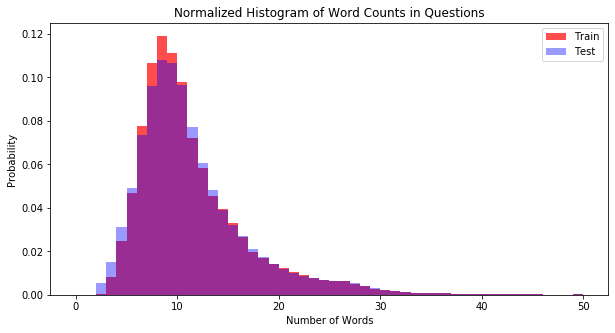

In [232]:
# count words
word_count_train = [len(w.split(' ')) for w in txt_train]
word_count_test = [len(w.split(' ')) for w in txt_test]
# get statistics
print('\n', '-'*15+'Word Counts Comparison'+'-'*15, '\n')
print('Mean word counts (train): {}'.format(round(mean(word_count_train), 2)))
print('Mean word counts (test): {}'.format(round(mean(word_count_test), 2)))
print('Standard deviation word counts (train): {}'.format(round(stdev(word_count_train), 2)))
print('Standard deviation word counts (test): {}'.format(round(stdev(word_count_test), 2)))
print('Max word counts (train): {}'.format(max(word_count_train)))
print('Max word counts (test): {}'.format(max(word_count_test)))
print('Min word counts (train): {}'.format(min(word_count_train)))
print('Min word counts (test): {}'.format(min(word_count_test)), '\n')

# Get visualization
plt.figure(figsize=(10, 5))
# density is the same as 'normed' in new version
plt.hist(word_count_train, bins=50, range=[0, 50], density=True, 
         color='red', alpha=0.7, label='Train')
# alpha makes transparent to see overlaps
plt.hist(word_count_test, bins=50, range=[0, 50], density=True, 
         color='blue', alpha=0.4, label='Test')
plt.title('Normalized Histogram of Word Counts in Questions', fontsize=12)
plt.xlabel('Number of Words')
plt.ylabel('Probability')
plt.legend()
plt.show()

### Compare character counts


 ---------------Character Counts Comparison--------------- 

Mean character counts (train): 59.82
Mean character counts (test): 60.07
Standard deviation character counts (train): 31.96
Standard deviation character counts (test): 31.62
Max character counts (train): 1169
Max character counts (test): 1176
Min character counts (train): 1
Min character counts (test): 1 



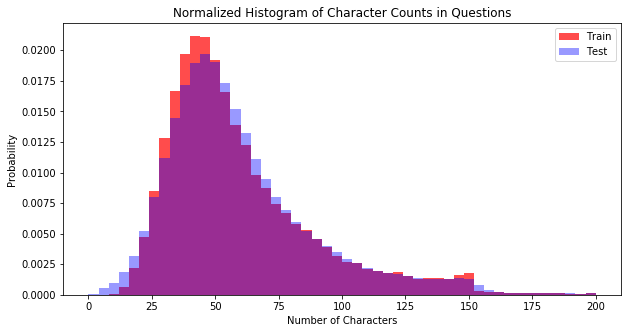

In [236]:
# count characters in each string
char_count_train = [len(w) for w in txt_train]
char_count_test = [len(w) for w in txt_test]
# get statistics
print('\n', '-'*15+'Character Counts Comparison'+'-'*15, '\n')
print('Mean character counts (train): {}'.format(round(mean(char_count_train), 2)))
print('Mean character counts (test): {}'.format(round(mean(char_count_test), 2)))
print('Standard deviation character counts (train): {}'.format(round(stdev(char_count_train), 2)))
print('Standard deviation character counts (test): {}'.format(round(stdev(char_count_test), 2)))
print('Max character counts (train): {}'.format(max(char_count_train)))
print('Max character counts (test): {}'.format(max(char_count_test)))
print('Min character counts (train): {}'.format(min(char_count_train)))
print('Min character counts (test): {}'.format(min(char_count_test)), '\n')

# Get visualization
plt.figure(figsize=(10, 5))
# density is the same as 'normed' in new version
plt.hist(char_count_train, bins=50, range=[0, 200], density=True, 
         color='red', alpha=0.7, label='Train')
# alpha makes transparent to see overlaps
plt.hist(char_count_test, bins=50, range=[0, 200], density=True, 
         color='blue', alpha=0.4, label='Test')
plt.title('Normalized Histogram of Character Counts in Questions', fontsize=12)
plt.xlabel('Number of Characters')
plt.ylabel('Probability')
plt.legend()
plt.show()

### Word Cloud

(-0.5, 1449.5, 999.5, -0.5)

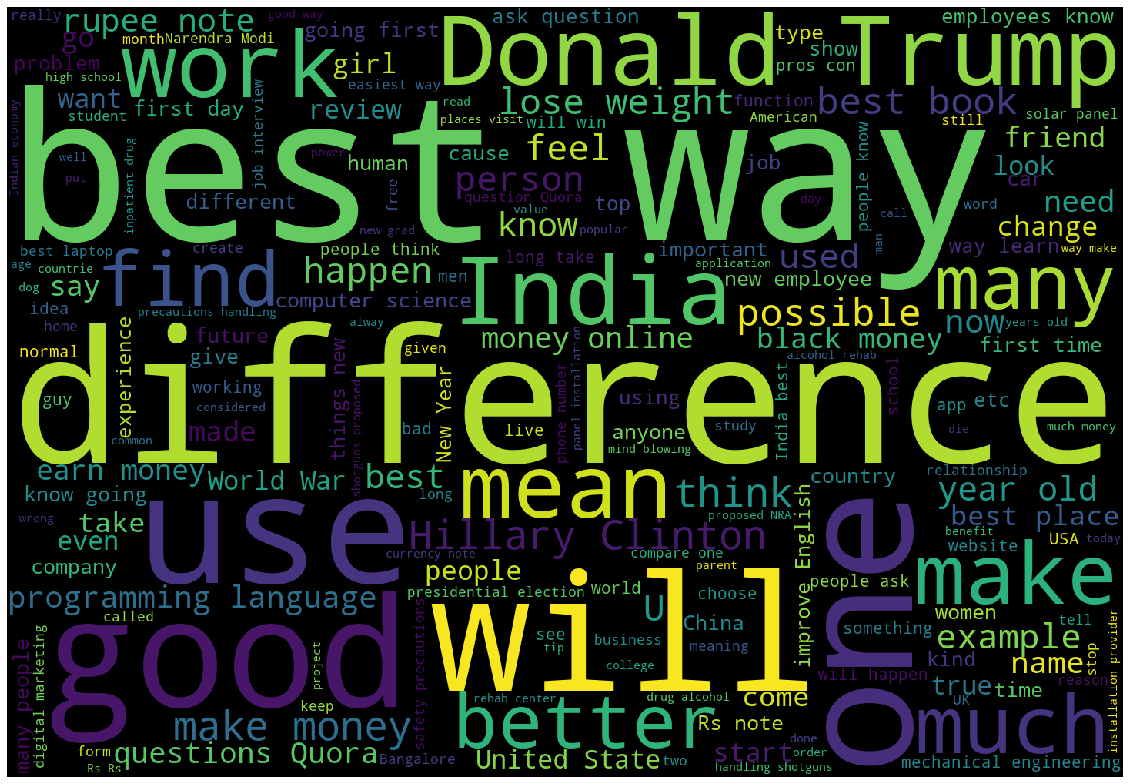

In [239]:
cloud = WordCloud(width=1450, height=1000).generate(' '.join(txt_train.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

## Semantic Analysis

In this section, we take a look at usage of different punctuations in questions

In [247]:
# question marks
qmarks = np.mean(txt_train.apply(lambda x: '?' in x))
# math symbols
math = np.mean(txt_train.apply(lambda x: '[math]' in x))
# full stop
period = np.mean(txt_train.apply(lambda x: '.' in x))
# first letter capital
cap_first = np.mean(txt_train.apply(lambda x: x[0].isupper()))
# all capital
capital = np.mean(txt_train.apply(lambda x: max([y.isupper() for y in x])))
num = np.mean(txt_train.apply(lambda x: max([y.isdigit() for y in x])))

# check results
print('\n', '-'*15+'Different Punctuations'+'-'*15, '\n')
print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(period * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(cap_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capital * 100))
print('Questions with numbers: {:.2f}%'.format(num * 100))


 ---------------Different Punctuations--------------- 

Questions with question marks: 99.87%
Questions with [math] tags: 0.12%
Questions with full stops: 6.31%
Questions with capitalised first letters: 99.81%
Questions with capital letters: 99.95%
Questions with numbers: 11.83%


## Initial Feature Analysis

In this section, we look at how powerful some features are before building models.

In [248]:
stop = set(stopwords.words("english"))

def word_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stop:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stop:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


Text(0.5, 0, 'Word Share')

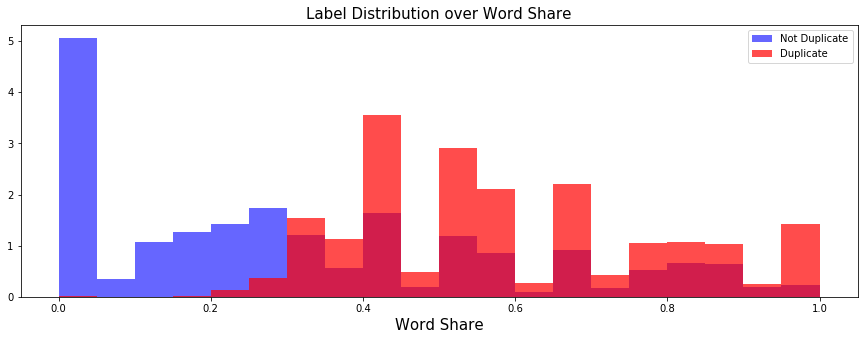

In [254]:
plt.figure(figsize=(15, 5))
train_word_match = qs_train.apply(word_share, axis=1, raw=True)
plt.hist(train_word_match[qs_train['is_duplicate'] == 0], bins=20, normed=True, color='blue', alpha=0.6, label='Not Duplicate')
plt.hist(train_word_match[qs_train['is_duplicate'] == 1], bins=20, normed=True, color='red', alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label Distribution over Word Share', fontsize=15)
plt.xlabel('Word Share', fontsize=15)

This feature has much predictive power as it helps to distinguish the duplicate questions and non-duplicate questions. However, it is quite good at identifying questions that are totally different, but is not so good at finding questions which are definitely duplicates.

### TFIDF

In [258]:
# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(txt_train)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 2.5891040146646852e-06), ('what', 3.115623919267953e-06), ('is', 3.5861702928825277e-06), ('how', 4.366449945201053e-06), ('i', 4.4805878531263305e-06), ('a', 4.540645588989843e-06), ('to', 4.671434644293609e-06), ('in', 4.884625153865692e-06), ('of', 5.920242493132519e-06), ('do', 6.070908207867897e-06)]

Least common words and weights: 


[('シ', 9.998000399920016e-05),
 ('し?', 9.998000399920016e-05),
 ('19-year-old.', 9.998000399920016e-05),
 ('1-855-425-3768', 9.998000399920016e-05),
 ('confederates', 9.998000399920016e-05),
 ('asahi', 9.998000399920016e-05),
 ('fab', 9.998000399920016e-05),
 ('109?', 9.998000399920016e-05),
 ('samrudi', 9.998000399920016e-05),
 ('fulfill?', 9.998000399920016e-05)]

In [262]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stop:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stop:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


Text(0.5, 0, 'Word Share')

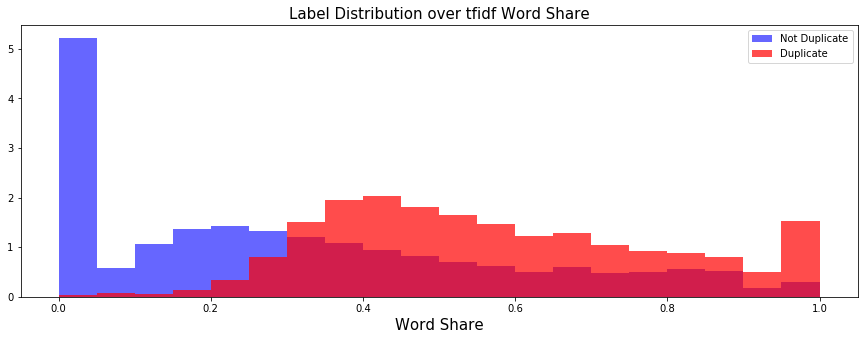

In [263]:
plt.figure(figsize=(15, 5))
tfidf_train_word_match = qs_train.apply(tfidf_word_match_share, axis=1, raw=True)
plt.hist(tfidf_train_word_match[qs_train['is_duplicate'] == 0].fillna(0), bins=20, normed=True, color='blue', alpha=0.6, label='Not Duplicate')
plt.hist(tfidf_train_word_match[qs_train['is_duplicate'] == 1].fillna(0), bins=20, normed=True, color='red', alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label Distribution over tfidf Word Share', fontsize=15)
plt.xlabel('Word Share', fontsize=15)

In [264]:
print('Original AUC:', roc_auc_score(qs_train['is_duplicate'], train_word_match))
print('   TFIDF AUC:', roc_auc_score(qs_train['is_duplicate'], tfidf_train_word_match.fillna(0)))

Original AUC: 0.7804327049353577
   TFIDF AUC: 0.7704802292218704


### More Features

In [406]:
# question 1 length and word counts
qs_train['q1len'] = qs_train.question1.str.len()
qs_train['q1_n_words'] = qs_train.question1.apply(lambda row: len(row.split(" ")))
# question 2 length and word counts
qs_train['q2len'] = qs_train.question2.str.len()
qs_train['q2_n_words'] = qs_train.question2.apply(lambda row: len(row.split(" ")))
# add word share as a feature
def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row.question1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row.question2.split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
qs_train['word_share'] = qs_train.apply(normalized_word_share, axis=1)
qs_train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q1_n_words,q2len,q2_n_words,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,14,57,12,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,8,88,13,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,14,59,10,0.166667


### Rebalancing the Data

In [266]:
# First we create our training and testing data
x_train = pd.DataFrame()
x_test = pd.DataFrame()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
x_test['word_match'] = qs_test.apply(word_share, axis=1, raw=True)
x_test['tfidf_word_match'] = qs_test.apply(tfidf_word_match_share, axis=1, raw=True)

y_train = qs_train['is_duplicate'].values

pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


0.19124366100096607


In [396]:
# Finally, we split some of the data off for validation
from sklearn.model_selection import train_test_split, GridSearchCV

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

## Modeling

### Logistic Regression
- Experiment 1: C=1e-6, penalty=l1
- Experiment 2: C=1e-6, penalty=l2
- Experiment 3: C=1e-3, penalty=l1
- Experiment 4: C=1e-3, penalty=l2
- Experiment 5: C=1e0, penalty=l1
- Experiment 6: C=1e0, penalty=l2

In [420]:
scaler = MinMaxScaler().fit(qs_train[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share']])

# scale 
X = scaler.transform(qs_train[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share']])
y = qs_train['is_duplicate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# logistic regression
# run cross-validation with a few hyper parameters
clf = LogisticRegression()
grid = {
    'C': [1e-6, 1e-3, 1e0],
    'penalty': ['l1', 'l2']
}
cv = GridSearchCV(clf, grid, scoring='neg_log_loss', n_jobs=-1, verbose=1)
cv.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   18.7s finished
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1e-06, 0.001, 1.0], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=1)

In [427]:
# print validation results
for i in range(1, len(cv.cv_results_['params'])+1):
    rank = cv.cv_results_['rank_test_score'][i-1]
    s = cv.cv_results_['mean_test_score'][i-1]
    params = cv.cv_results_['params'][i-1]
    print("{0}. Mean validation neg log loss: {1:.4f} - {2}".format(
        rank, s, params
    ))

6. Mean validation neg log loss: -0.6931 - {'C': 1e-06, 'penalty': 'l1'}
5. Mean validation neg log loss: -0.6901 - {'C': 1e-06, 'penalty': 'l2'}
3. Mean validation neg log loss: -0.5824 - {'C': 0.001, 'penalty': 'l1'}
4. Mean validation neg log loss: -0.5865 - {'C': 0.001, 'penalty': 'l2'}
1. Mean validation neg log loss: -0.5682 - {'C': 1.0, 'penalty': 'l1'}
2. Mean validation neg log loss: -0.5685 - {'C': 1.0, 'penalty': 'l2'}


### XGBoost
- Experiment 1: eta=0.02, max_depth=4
- Experiment 2: eta=0.02, max_depth=6
- Experiment 3: eta=0.02, max_depth=8
- Experiment 4: eta=0.2, max_depth=4
- Experiment 5: eta=0.2, max_depth=6
- Experiment 6: eta=0.2, max_depth=8

In [414]:
# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.2 #0.02, 0.2
params['max_depth'] = 8 #4, 6, 8

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.600569	valid-logloss:0.602027
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.377264	valid-logloss:0.380921
[20]	train-logloss:0.358398	valid-logloss:0.362827
[30]	train-logloss:0.35598	valid-logloss:0.360545
[40]	train-logloss:0.354738	valid-logloss:0.359774
[50]	train-logloss:0.353956	valid-logloss:0.359488
[60]	train-logloss:0.352586	valid-logloss:0.358825
[70]	train-logloss:0.351607	valid-logloss:0.35854
[80]	train-logloss:0.350793	valid-logloss:0.358296
[90]	train-logloss:0.349992	valid-logloss:0.357941
[100]	train-logloss:0.349043	valid-logloss:0.357529
[110]	train-logloss:0.348342	valid-logloss:0.357334
[120]	train-logloss:0.347489	valid-logloss:0.357132
[130]	train-logloss:0.346826	valid-logloss:0.356931
[140]	train-logloss:0.345895	valid-logloss:0.356624
[150]	train-logloss:0.345003	valid-logloss:0.356307
[160]	train-logloss:0.344143	v

In [430]:
# save model to pickle
filename = 'best_model.sav'
pickle.dump(bst, open(filename, 'wb'))

In [358]:
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = qs_test['test_id']
sub['is_duplicate'] = p_test

In [359]:
sub.head(10)

,test_id,is_duplicate
0,0,0.031157
1,1,0.364592
2,2,0.361959
3,3,0.000817
4,4,0.190522
5,5,0.017305
6,6,0.366538
7,7,0.370580
8,8,0.360470
9,9,0.013050


In [285]:
qs_test.head(10)

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?
5,5,How are the two wheeler insurance from Bharti ...,I admire I am considering of buying insurance ...
6,6,How can I reduce my belly fat through a diet?,How can I reduce my lower belly fat in one month?
7,7,"By scrapping the 500 and 1000 rupee notes, how...",How will the recent move to declare 500 and 10...
8,8,What are the how best books of all time?,What are some of the military history books of...
9,9,After 12th years old boy and I had sex with a ...,Can a 14 old guy date a 12 year old girl?


In [381]:
print('Please enter the questions you want to compare below: ', '\n')
q1_in = input("Please enter the 1st question: ")
q2_in = input("Please enter the 2nd question: ")

Please enter the questions you want to compare below:  

Please enter the 1st question: How can I reduce my belly fat through a diet?	
Please enter the 2nd question: How can I reduce my lower belly fat in one month?


In [382]:
qs_in = pd.DataFrame({'test_id': [999999], 'question1': [q1_in], 'question2': [q2_in]})
qs_in

,test_id,question1,question2
0,999999,How can I reduce my belly fat through a diet?\t,How can I reduce my lower belly fat in one month?


In [431]:
qs_in_test = pd.DataFrame()
qs_in_test['word_match'] = qs_in.apply(word_share, axis=1, raw=True)
qs_in_test['tfidf_word_match'] = qs_in.apply(tfidf_word_match_share, axis=1, raw=True)

In [432]:
qs_in_test

,word_match,tfidf_word_match
0,0.6,0.624099


In [433]:
d_test = xgb.DMatrix(qs_in_test)
p_test = bst.predict(d_test)

In [434]:
p_test

array([0.45393452], dtype=float32)